## 1. Train a Random Forest Regressor for the dataset. Find the best model based on R-squared value using RandomizedSearchCV. [10 Marks]

In [1]:
# Load in the data.
import matplotlib.pyplot as plt
import pandas as pd
import ssl 

ssl._create_default_https_context = ssl._create_unverified_context
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
df = pd.read_csv(url, sep = ";")
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

X_train = df.loc[0:3918, "fixed acidity":"alcohol"]
y_train = df.loc[0:3918]["quality"]

In [3]:
print(df.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [4]:
# Import and use Random Forest Regressor.
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)

#Build forest of trees using training set regr.fit()
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

#### Density, Free Sulfur Dioxide, and Volatile Acidity are the top 3 important features.

In [5]:
# See the important features
for feature, importance in (zip(df.columns[0:10], regr.feature_importances_)):
    print("\nFeature importance: {} - {}".format(feature, importance))


Feature importance: fixed acidity - 0.0007748084902428776

Feature importance: volatile acidity - 0.18768686009271623

Feature importance: citric acid - 0.0

Feature importance: residual sugar - 0.0

Feature importance: chlorides - 0.0

Feature importance: free sulfur dioxide - 0.10182327318633203

Feature importance: total sulfur dioxide - 0.0

Feature importance: density - 0.0

Feature importance: pH - 0.0

Feature importance: sulphates - 0.0


In [6]:
# Look at initial R^2 of the prediction
print("\nInitial R^2 of prediction:\n {}".format(regr.score(X_train, y_train)))



Initial R^2 of prediction:
 0.26884948543187304


In [7]:
# Find the best model based om R^2 value using RandomizedSearchCV.
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

distributions = dict(
    max_depth=[item for item in range(1, 50)], 
    min_samples_split=[item for item in range(1, 50)],
    min_samples_leaf=[item for item in range(1,50)],
    max_features=["auto", "sqrt", "log2"],
)
clf = RandomizedSearchCV(regr, distributions, random_state=0, scoring="r2", n_jobs=-1)
search = clf.fit(X_train, y_train)

#### Best model parameters. 

In [8]:
print(search.best_params_)
print("\nOptimized R^2 of prediction:\n {}".format(search.score(X_train, y_train)))

{'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 24}

Optimized R^2 of prediction:
 0.7222348815574778


In [9]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(search.cv_results_)

{   'mean_fit_time': array([0.10995135, 0.94894905, 1.48168354, 1.20711098, 1.92303343,
       0.57184863, 0.71212153, 0.57691913, 1.26036677, 0.68145757]),
    'mean_score_time': array([0.        , 0.04019518, 0.02179098, 0.02288861, 0.02143135,
       0.0215313 , 0.02451921, 0.02027459, 0.01858168, 0.02390642]),
    'mean_test_score': array([       nan, 0.32551605, 0.30661979, 0.30382194, 0.3086933 ,
       0.29326017, 0.31679811, 0.31872945, 0.3078601 , 0.32883006]),
    'param_max_depth': masked_array(data=[43, 17, 22, 43, 18, 12, 30, 30, 44, 24],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
    'param_max_features': masked_array(data=['sqrt', 'sqrt', 'auto', 'auto', 'auto', 'log2', 'sqrt',
                   'sqrt', 'auto', 'log2'],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
      

## 2. Use the best model from question 1 for model interpretation and rank the features based on drop feature importance. [15 Marks]

In [10]:
import numpy as np 
from sklearn.model_selection import cross_val_score

def drop_feature_importance(est, X_train, y_train):
    base_score = np.mean(cross_val_score(est, X_train, y_train))
    scores = []
    for feature in range(X_train.shape[1]):
        mask = np.ones(X_train.shape[1], 'bool')
        mask[feature] = False
        X_new = X_train.iloc[:, mask]
        this_score = np.mean(cross_val_score(est, X_new, y_train))
        scores.append(base_score - this_score)
    return np.array(scores)

In [11]:
regr = RandomForestRegressor(random_state=0, min_samples_split= 16, min_samples_leaf=3, max_features='log2', max_depth=24)
regr = regr.fit(X_train,y_train)
featureImportance = drop_feature_importance(regr, X_train, y_train)
line = "--------------------------"
print("{}\nDrop feature importance\n{}\n{}\n{}\nFeature Importance\n{}\n{}".format(
    line,
    line,
    df.columns[0:10], 
    line,
    line,
    featureImportance,
))

--------------------------
Drop feature importance
--------------------------
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates'],
      dtype='object')
--------------------------
Feature Importance
--------------------------
[0.00433886 0.02924078 0.00611305 0.00918863 0.00589281 0.03287781
 0.00279462 0.00792129 0.00698259 0.0044019  0.01064047]


In [12]:
ranked = [tuple((fName, fImportance)) for fName, fImportance in zip(df.columns[0:10], featureImportance)]

## The top ranked in ascending order
#### Meaning top three are: Free Sulfur Dioxide, Volatile Acidity, and Residual Sugar. 

In [13]:
for item in ranked:
    print("{} - {}".format(item[0], item[1]))

fixed acidity - 0.004338859566665687
volatile acidity - 0.0292407756175333
citric acid - 0.006113051553161553
residual sugar - 0.009188631868256525
chlorides - 0.005892808052636145
free sulfur dioxide - 0.032877812966214226
total sulfur dioxide - 0.002794619349653804
density - 0.007921293392274764
pH - 0.006982593644492219
sulphates - 0.00440190463701734


## 3. Use the best model from question 1 for model interpretation and rank the features based on permutation importance. [15 Marks]

In [14]:
from sklearn.utils import shuffle

def custom_permutation_importance(est, X_train, y_train, n_repeat=100):
    baseline_score = est.score(X_train, y_train)
    scores = pd.DataFrame(np.zeros((X_train.shape[1], n_repeat)))
    for f_idx in range(X_train.shape[1]):
        for repeat in range(n_repeat):
            X_new = X_train.copy()
            X_new.iloc[:, f_idx] = shuffle(X_train.iloc[:, f_idx])
            feature_score = est.score(X_new, y_train)
            #print("Feature Score: {}".format(feature_score), "Baseline Score: {}".format(baseline_score), "Baseline - Features Score = {}".format(baseline_score - feature_score),)
            scores.iloc[f_idx, repeat] = baseline_score - feature_score
    return scores

In [15]:
permImp = custom_permutation_importance(regr, X_train, y_train)

In [16]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(permImp)

     0    1    2    3    4    5    6    7    8    9   ...   90   91   92   93  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

     94   95   96   97   98

### So the above function that was included in the slides doesn't work. It seems to have an issue with copying the data over after the shuffle function, it doesn't throw an error, however, the X_new variable never gets data copied into it. Not sure why. Ultimately just looked at sklearn's module and took the code they had available. 

In [17]:
from sklearn.inspection import permutation_importance
df.shape

X_test = df.loc[3919:4898, "fixed acidity":"alcohol"]
y_test = df.loc[3919:4898]["quality"]

In [18]:
result = permutation_importance(regr, X_test, y_test,)
print(result)

{'importances_mean': array([ 0.00846857,  0.12499635,  0.03242051,  0.06466199,  0.01176597,
        0.07708456,  0.00882712,  0.04083229,  0.00696295, -0.00291215,
        0.23306129]), 'importances_std': array([0.00352278, 0.00744833, 0.00495467, 0.00580606, 0.0042344 ,
       0.00734883, 0.00453119, 0.01064763, 0.0024445 , 0.00232732,
       0.014423  ]), 'importances': array([[ 0.00996913,  0.00774541,  0.01128919,  0.01140485,  0.00193424],
       [ 0.12254534,  0.13005906,  0.12043533,  0.11541056,  0.13653148],
       [ 0.0409141 ,  0.02761934,  0.03467359,  0.03099702,  0.02789849],
       [ 0.0680095 ,  0.07408207,  0.06349023,  0.05882614,  0.058902  ],
       [ 0.01306246,  0.00760552,  0.01484165,  0.01719086,  0.00612937],
       [ 0.08435132,  0.08640091,  0.07298442,  0.07506817,  0.06661797],
       [ 0.00394973,  0.00885358,  0.00611363,  0.01724049,  0.00797814],
       [ 0.05305208,  0.02254014,  0.03887209,  0.04968752,  0.04000964],
       [ 0.00855883,  0.00262153

In [19]:
sorted_idx = result.importances_mean.argsort()

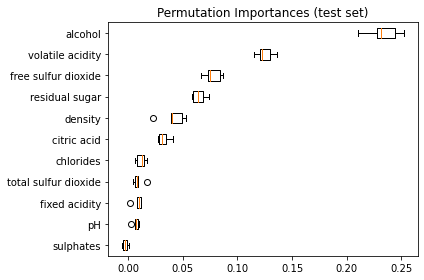

In [20]:
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])

ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## 4. Use the best model from question 1 for model interpretation and rank the features based on SHAP algorithm. Install SHAP using pip. [20 Marks]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


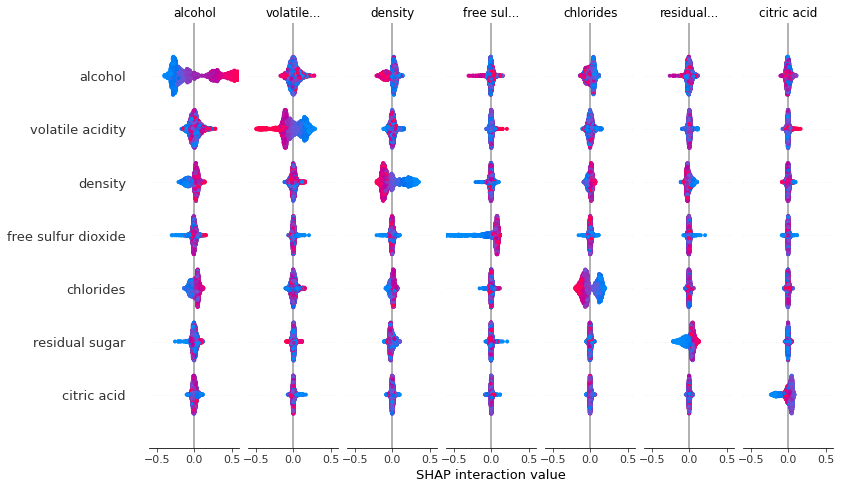

In [21]:
import shap
shap.summary_plot(
    shap.TreeExplainer(regr).shap_interaction_values(X_train),
    X_train,
    plot_type="bar"
)

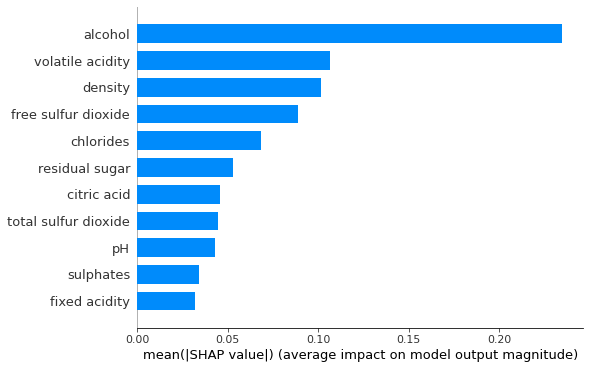

In [22]:
shap.summary_plot(shap.TreeExplainer(regr).shap_values(X_train), X_train, plot_type="bar")

## 5. Visualize partial dependence plot for each feature in the dataset using Sklearn. [10 Marks]

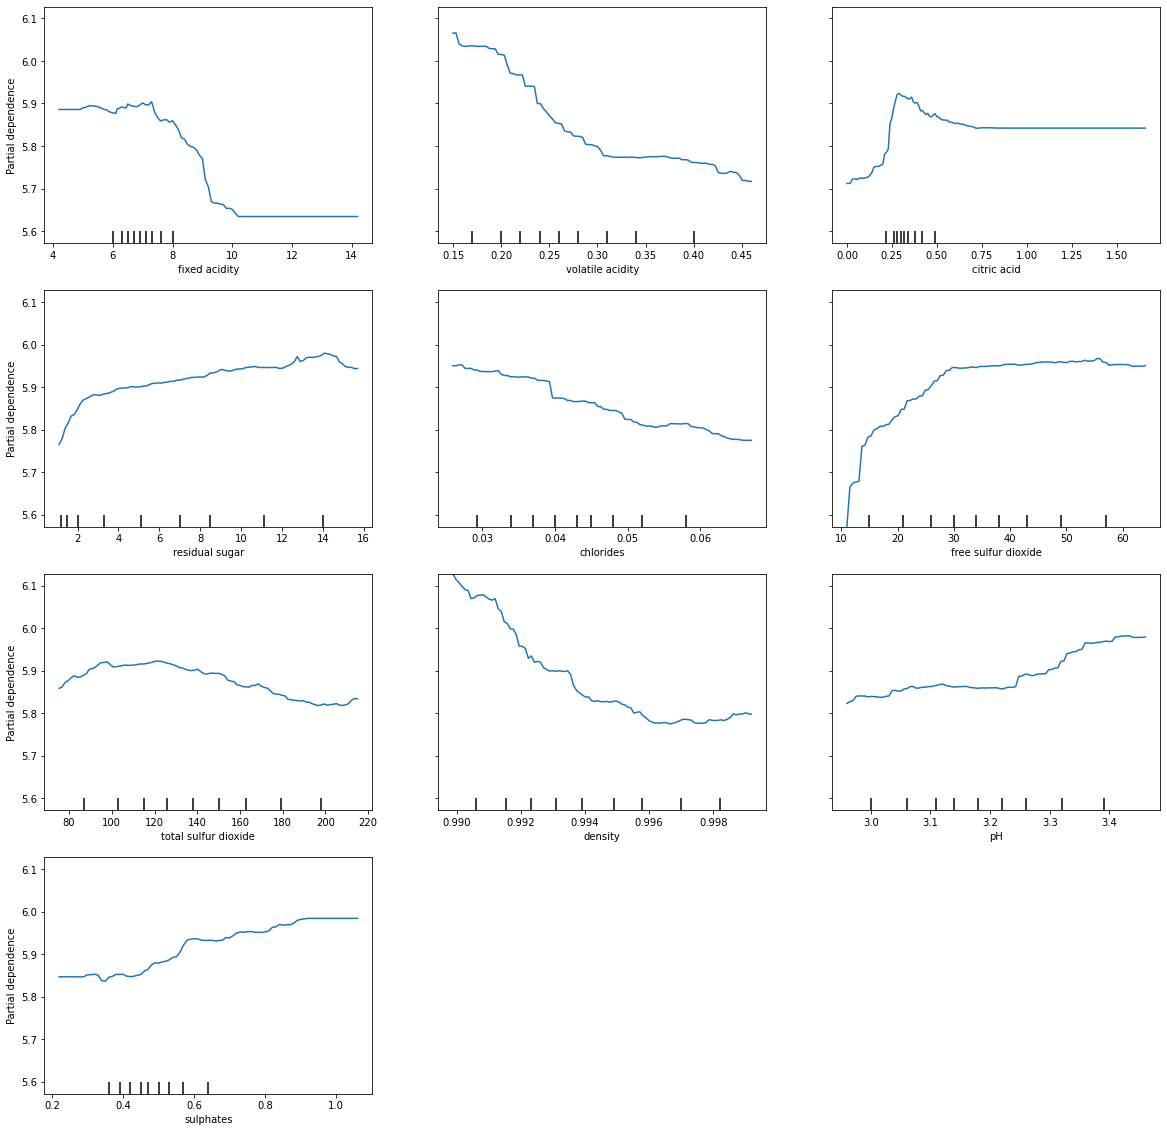

In [23]:
from sklearn.inspection import plot_partial_dependence
fig, axes = plt.subplots(figsize=(20,20)) 
plot_partial_dependence(regr, X_train, df.columns[0:10], ax=axes)

## 6. Visualize ICE plot for each feature using following library.

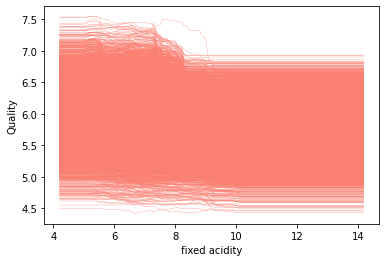

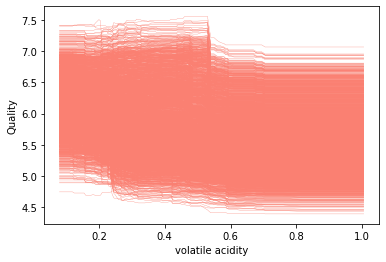

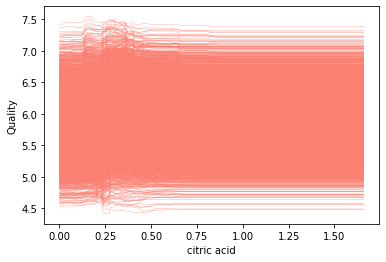

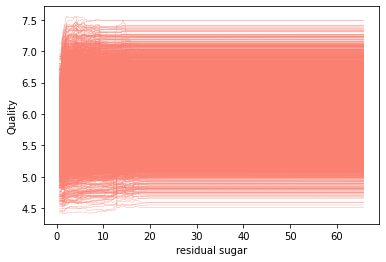

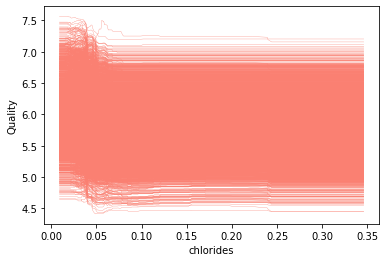

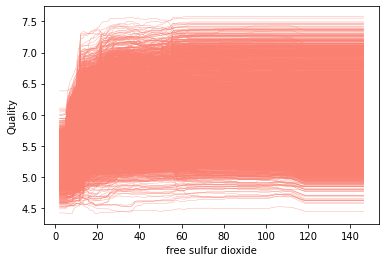

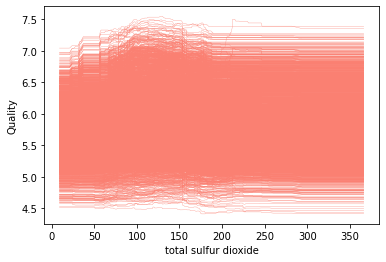

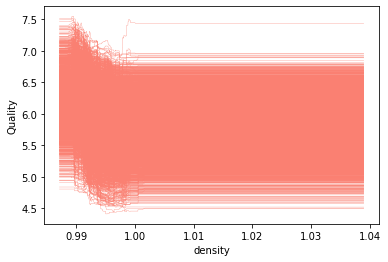

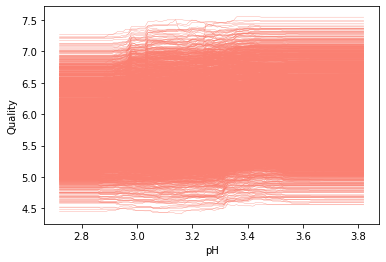

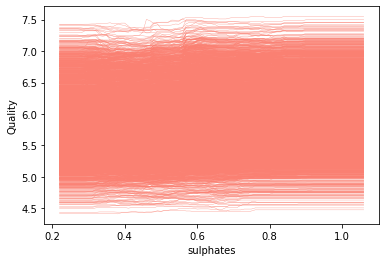

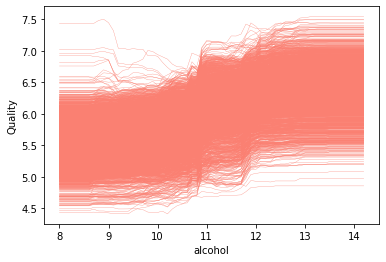

In [24]:
from pycebox.ice import ice, ice_plot

for column in X_train.iloc[:, 0:11]:
    ice_plot(ice(data=X_train, column=column, predict=regr.predict), c="salmon", linewidth=0.3)
    plt.ylabel("Quality")
    plt.xlabel(column)

## 7. Analyze outputs from each technique and comment that which technique you found most useful and why. [10 Marks]

1. Train a Random Forest Regressor for the dataset. Find the best model based on R-squared value using RandomizedSearchCV.
- This was rather straightforward. The hardest part was loading in the data. I found this to be very useful, probably the most useful technique because it was essentially grid search / ensemblesque. The improvement in R^2 value was great and easy. Like that you could fit a model in the same function call too. 
2. Use the best model from question 1 for model interpretation and rank the features based on drop feature importance.
- This made it possible to choose the top 3 features and was more robust than just scoring based on r^2 value. 
3. Use the best model from question 1 for model interpretation and rank the features based on permutation importance.
- It was still very important to see what the top 3 features are. That makes the model more explainable, faster, and easier to debug. It was interesting to see that it thought differently than the previous feature importance selection method.
4. Use the best model from question 1 for model interpretation and rank the features based on SHAP algorithm. Install SHAP using pip.
- This ran forever. The first chart was not as easy to interpret as the simple bar chart. I also installed shap locally. May need a !pip install if you run in collab. 
5. Visualize partial dependence plot for each feature in the dataset using Sklearn.
- More useful than SHAP imo, was interesting to see how each feature was impacted the predicted outcome. 
6. Visualize ICE plot for each feature using following library.
- The ice plot was more insightful than the PDP because it allowed for understanding how the model works at each interaction.